# In preparation ...

In [1]:
%%capture
import tensorflow as tf

2023-05-11 13:49:40.080958: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-11 13:49:40.168920: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-11 13:49:40.171467: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-11 13:49:40.171476: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

just for downloading the some data in place of your data.

In [2]:
%%capture
from kgcnn.data.datasets.ESOLDataset import ESOLDataset
ESOLDataset()

move the data from "~/.kgcnn.datasets.esol" to your local "esol" folder. The ESOL data is just some example data for this notebook.

In [3]:
from kgcnn.data.moleculenet import MoleculeNetDataset

In [4]:
data = MoleculeNetDataset(
    data_directory="esol/",
    dataset_name="esol",
    file_name="delaney-processed.csv",
)

In [5]:
data.prepare_data(
    overwrite=True,
    smiles_column_name="smiles",
    add_hydrogen=True, 
    sanitize=True,
    make_conformers=True, 
    optimize_conformer=True,
    external_program=None, 
    num_workers=None
);

In [6]:
%%capture
from kgcnn.molecule.encoder import OneHotEncoder
data.read_in_memory(
    nodes = [
        'Symbol', 'TotalDegree', 'FormalCharge', 'NumRadicalElectrons', 'Hybridization',
        'IsAromatic', 'IsInRing', 'TotalNumHs', 'CIPCode', "ChiralityPossible", "ChiralTag"
    ],
    encoder_nodes = {
        'Symbol': OneHotEncoder(
            ['B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'As', 'Se', 'Br', 'Te', 'I', 'At'],
            dtype="str"
        ),
        'Hybridization': OneHotEncoder([2, 3, 4, 5, 6]),
        'TotalDegree': OneHotEncoder([0, 1, 2, 3, 4, 5], add_unknown=False),
        'TotalNumHs': OneHotEncoder([0, 1, 2, 3, 4], add_unknown=False),
        'CIPCode': OneHotEncoder(['R', 'S'], add_unknown=False, dtype='str'),
        "ChiralityPossible": OneHotEncoder(["1"], add_unknown=False, dtype='str'),
    },
    edges = ['BondType', 'IsAromatic', 'IsConjugated', 'IsInRing', 'Stereo'],
    encoder_edges = {
        'BondType': OneHotEncoder([1, 2, 3, 12], add_unknown=False),
        'Stereo': OneHotEncoder([0, 1, 2, 3], add_unknown=False)
    },
    graph=['ExactMolWt', 'NumAtoms'],
    encoder_graph = {},
    add_hydrogen=False,
    make_directed=False,
    has_conformers=True,
    sanitize=False,
    compute_partial_charges=None,
    label_column_name="measured log solubility in mols per litre"
)

In [7]:
from kgcnn.graph.preprocessor import SetRange, SetEdgeIndicesReverse
data.map_list(SetRange(max_distance=5.0, in_place=True));
data.map_list(SetEdgeIndicesReverse(in_place=True));

In [8]:
data[0].keys()

dict_keys(['node_symbol', 'node_number', 'edge_indices', 'edge_number', 'graph_size', 'node_coordinates', 'graph_labels', 'node_attributes', 'edge_attributes', 'graph_attributes', 'range_indices', 'range_attributes', 'edge_indices_reverse'])

In [9]:
import numpy as np
labels = np.array(data.obtain_property("graph_labels"))
if len(labels.shape) <= 1:
    labels = np.expand_dims(labels, axis=-1)

In [10]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, random_state=42, shuffle=True)
train_test_indices = [
    [train_index, test_index] for train_index, test_index in kf.split(X=np.zeros((len(data), 1)), y=labels)]

In [11]:
model_config= {
    "class_name": "make_model",
    "module_name": "kgcnn.literature.DMPNN",
    "config": {
        "name": "DMPNN",
        "inputs": [
            {"shape": [None, 41], "name": "node_attributes", "dtype": "float32", "ragged": True},
            {"shape": [None, 11], "name": "edge_attributes", "dtype": "float32", "ragged": True},
            {"shape": [None, 2], "name": "edge_indices", "dtype": "int64", "ragged": True},
            {"shape": [None, 1], "name": "edge_indices_reverse", "dtype": "int64", "ragged": True}
        ],
        "input_embedding": {"node": {"input_dim": 95, "output_dim": 64},
                            "edge": {"input_dim": 5, "output_dim": 64}},
        "pooling_args": {"pooling_method": "sum"},
        "edge_initialize": {"units": 128, "use_bias": True, "activation": "relu"},
        "edge_dense": {"units": 128, "use_bias": True, "activation": "linear"},
        "edge_activation": {"activation": "relu"},
        "node_dense": {"units": 128, "use_bias": True, "activation": "relu"},
        "verbose": 10, "depth": 5,
        "dropout": {"rate": 0.1},
        "output_embedding": "graph",
        "output_mlp": {
            "use_bias": [True, True, False], "units": [64, 32, 1],
            "activation": ["relu", "relu", "linear"]
        }
    }
}

In [12]:
import time
from kgcnn.model.utils import get_model_class
from tensorflow.keras.optimizers import Adam
from kgcnn.training.scheduler import LinearLearningRateScheduler
from kgcnn.literature.DMPNN import make_model
from kgcnn.data.transform.scaler.molecule import QMGraphLabelScaler
from kgcnn.data.transform.scaler.standard import StandardLabelScaler, StandardScaler
from kgcnn.metrics.metrics import ScaledMeanAbsoluteError, ScaledRootMeanSquaredError
from datetime import timedelta

history_list, test_indices_list = [], []
model, hist, x_test, y_test, scaler, atoms_test = None, None, None, None, None, None
splits_done = 0
for i, (train_index, test_index) in enumerate(train_test_indices):
    print("Running training on fold: %s" % i)

    # Make the model for current split using model kwargs from hyperparameter.
    # They are always updated on top of the models default kwargs.
    model = make_model(**model_config["config"])

    # First select training and test graphs from indices, then convert them into tensorflow tensor
    # representation. Which property of the dataset and whether the tensor will be ragged is retrieved from the
    # kwargs of the keras `Input` layers ('name' and 'ragged').
    dataset_train, dataset_test = data[train_index], data[test_index]
    x_train, y_train = dataset_train.tensor(model_config["config"]["inputs"]), labels[train_index]
    x_test, y_test = dataset_test.tensor(model_config["config"]["inputs"]), labels[test_index]
    
    atoms_test = dataset_test.get("node_number")
    atoms_train = dataset_train.get("node_number")
    
    scaler = StandardScaler(with_std=True,with_mean=True, copy=True)
    scaler.fit(y_train, atomic_number=atoms_train)
    y_train = scaler.transform(y_train, atomic_number=atoms_train)
    y_test = scaler.transform(y_test, atomic_number=atoms_test)

    # If scaler was used we add rescaled standard metrics to compile.
    scaler_scale = scaler.get_scaling()
    mae_metric = ScaledMeanAbsoluteError(scaler_scale.shape, name="scaled_mean_absolute_error")
    rms_metric = ScaledRootMeanSquaredError(scaler_scale.shape, name="scaled_root_mean_squared_error")
    if scaler.scale_ is not None:
        mae_metric.set_scale(scaler_scale)
        rms_metric.set_scale(scaler_scale)
    metrics = [mae_metric, rms_metric]

    # Compile model with optimizer and loss
    model.compile(loss="mean_absolute_error", metrics=metrics, optimizer=Adam(lr=5e-04))
    print(model.summary())

    # Start and time training
    start = time.process_time()
    hist = model.fit(x_train, y_train,
                     validation_data=(x_test, y_test),
                     batch_size=32, 
                     epochs=300, 
                     validation_freq=10, 
                     # Change to verbose = 2 to see progress
                     verbose=2,
                     callbacks= [
                         LinearLearningRateScheduler(
                             learning_rate_start=0.001, learning_rate_stop=1e-05, epo_min=100, epo=300)
                     ])
    stop = time.process_time()
    print("Print Time for training: ", str(timedelta(seconds=stop - start)))

    # Get loss from history
    history_list.append(hist)
    test_indices_list.append([train_index, test_index])
    splits_done = splits_done + 1

Running training on fold: 0


2023-05-11 13:49:53.148831: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-11 13:49:53.148848: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-11 13:49:53.148863: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (patrick-tuxedoinfinitybookpro14gen6): /proc/driver/nvidia/version does not exist
2023-05-11 13:49:53.148998: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "DMPNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 node_attributes (InputLayer)   [(None, None, 41)]   0           []                               
                                                                                                  
 optional_input_embedding (Opti  (None, None, 41)    0           ['node_attributes[0][0]']        
 onalInputEmbedding)                                                                              
                                                                                                  
 edge_indices (InputLayer)      [(None, None, 2)]    0           []                               
                                                                                                  
 edge_attributes (InputLayer)   [(None, None, 11)]   0           []                           

                                                                  'edge_indices[0][0]',           
                                                                  'edge_indices_reverse[0][0]']   
                                                                                                  
 lazy_add_3 (LazyAdd)           (None, None, 128)    0           ['dense_embedding_1[3][0]',      
                                                                  'dense_embedding[0][0]']        
                                                                                                  
 activation_embedding_3 (Activa  (None, None, 128)   0           ['lazy_add_3[0][0]']             
 tionEmbedding)                                                                                   
                                                                                                  
 dropout_embedding_3 (DropoutEm  (None, None, 128)   0           ['activation_embedding_3[0][0]'] 
 bedding) 

Epoch 24/300
29/29 - 1s - loss: 0.3578 - scaled_mean_absolute_error: 0.7425 - scaled_root_mean_squared_error: 0.9773 - lr: 0.0010 - 727ms/epoch - 25ms/step
Epoch 25/300
29/29 - 1s - loss: 0.3207 - scaled_mean_absolute_error: 0.6656 - scaled_root_mean_squared_error: 0.8598 - lr: 0.0010 - 750ms/epoch - 26ms/step
Epoch 26/300
29/29 - 1s - loss: 0.3679 - scaled_mean_absolute_error: 0.7636 - scaled_root_mean_squared_error: 0.9827 - lr: 0.0010 - 730ms/epoch - 25ms/step
Epoch 27/300
29/29 - 1s - loss: 0.3185 - scaled_mean_absolute_error: 0.6610 - scaled_root_mean_squared_error: 0.8709 - lr: 0.0010 - 739ms/epoch - 25ms/step
Epoch 28/300
29/29 - 1s - loss: 0.3034 - scaled_mean_absolute_error: 0.6297 - scaled_root_mean_squared_error: 0.8199 - lr: 0.0010 - 732ms/epoch - 25ms/step
Epoch 29/300
29/29 - 1s - loss: 0.2966 - scaled_mean_absolute_error: 0.6156 - scaled_root_mean_squared_error: 0.8142 - lr: 0.0010 - 730ms/epoch - 25ms/step
Epoch 30/300
29/29 - 1s - loss: 0.2955 - scaled_mean_absolute_er

Epoch 74/300
29/29 - 1s - loss: 0.1857 - scaled_mean_absolute_error: 0.3853 - scaled_root_mean_squared_error: 0.5374 - lr: 0.0010 - 653ms/epoch - 23ms/step
Epoch 75/300
29/29 - 1s - loss: 0.1840 - scaled_mean_absolute_error: 0.3819 - scaled_root_mean_squared_error: 0.5324 - lr: 0.0010 - 656ms/epoch - 23ms/step
Epoch 76/300
29/29 - 1s - loss: 0.1844 - scaled_mean_absolute_error: 0.3826 - scaled_root_mean_squared_error: 0.5309 - lr: 0.0010 - 661ms/epoch - 23ms/step
Epoch 77/300
29/29 - 1s - loss: 0.1811 - scaled_mean_absolute_error: 0.3759 - scaled_root_mean_squared_error: 0.5246 - lr: 0.0010 - 673ms/epoch - 23ms/step
Epoch 78/300
29/29 - 1s - loss: 0.1792 - scaled_mean_absolute_error: 0.3719 - scaled_root_mean_squared_error: 0.5196 - lr: 0.0010 - 668ms/epoch - 23ms/step
Epoch 79/300
29/29 - 1s - loss: 0.1927 - scaled_mean_absolute_error: 0.3999 - scaled_root_mean_squared_error: 0.5468 - lr: 0.0010 - 660ms/epoch - 23ms/step
Epoch 80/300
29/29 - 1s - loss: 0.1804 - scaled_mean_absolute_er

Epoch 123/300
29/29 - 1s - loss: 0.1383 - scaled_mean_absolute_error: 0.2869 - scaled_root_mean_squared_error: 0.4114 - lr: 8.9110e-04 - 704ms/epoch - 24ms/step
Epoch 124/300
29/29 - 1s - loss: 0.1412 - scaled_mean_absolute_error: 0.2930 - scaled_root_mean_squared_error: 0.4240 - lr: 8.8615e-04 - 685ms/epoch - 24ms/step
Epoch 125/300
29/29 - 1s - loss: 0.1394 - scaled_mean_absolute_error: 0.2893 - scaled_root_mean_squared_error: 0.4120 - lr: 8.8120e-04 - 737ms/epoch - 25ms/step
Epoch 126/300
29/29 - 1s - loss: 0.1365 - scaled_mean_absolute_error: 0.2834 - scaled_root_mean_squared_error: 0.4066 - lr: 8.7625e-04 - 804ms/epoch - 28ms/step
Epoch 127/300
29/29 - 1s - loss: 0.1453 - scaled_mean_absolute_error: 0.3015 - scaled_root_mean_squared_error: 0.4300 - lr: 8.7130e-04 - 733ms/epoch - 25ms/step
Epoch 128/300
29/29 - 1s - loss: 0.1413 - scaled_mean_absolute_error: 0.2933 - scaled_root_mean_squared_error: 0.4264 - lr: 8.6635e-04 - 688ms/epoch - 24ms/step
Epoch 129/300
29/29 - 1s - loss: 0

Epoch 171/300
29/29 - 1s - loss: 0.1151 - scaled_mean_absolute_error: 0.2388 - scaled_root_mean_squared_error: 0.3480 - lr: 6.5350e-04 - 689ms/epoch - 24ms/step
Epoch 172/300
29/29 - 1s - loss: 0.1269 - scaled_mean_absolute_error: 0.2633 - scaled_root_mean_squared_error: 0.3735 - lr: 6.4855e-04 - 827ms/epoch - 29ms/step
Epoch 173/300
29/29 - 1s - loss: 0.1198 - scaled_mean_absolute_error: 0.2486 - scaled_root_mean_squared_error: 0.3528 - lr: 6.4360e-04 - 829ms/epoch - 29ms/step
Epoch 174/300
29/29 - 1s - loss: 0.1184 - scaled_mean_absolute_error: 0.2457 - scaled_root_mean_squared_error: 0.3391 - lr: 6.3865e-04 - 745ms/epoch - 26ms/step
Epoch 175/300
29/29 - 1s - loss: 0.1273 - scaled_mean_absolute_error: 0.2641 - scaled_root_mean_squared_error: 0.3702 - lr: 6.3370e-04 - 816ms/epoch - 28ms/step
Epoch 176/300
29/29 - 1s - loss: 0.1250 - scaled_mean_absolute_error: 0.2595 - scaled_root_mean_squared_error: 0.3678 - lr: 6.2875e-04 - 929ms/epoch - 32ms/step
Epoch 177/300
29/29 - 1s - loss: 0

Epoch 220/300
29/29 - 1s - loss: 0.0997 - scaled_mean_absolute_error: 0.2068 - scaled_root_mean_squared_error: 0.3048 - val_loss: 0.2124 - val_scaled_mean_absolute_error: 0.4409 - val_scaled_root_mean_squared_error: 0.6589 - lr: 4.1095e-04 - 770ms/epoch - 27ms/step
Epoch 221/300
29/29 - 1s - loss: 0.1007 - scaled_mean_absolute_error: 0.2090 - scaled_root_mean_squared_error: 0.3055 - lr: 4.0600e-04 - 671ms/epoch - 23ms/step
Epoch 222/300
29/29 - 1s - loss: 0.0959 - scaled_mean_absolute_error: 0.1991 - scaled_root_mean_squared_error: 0.2930 - lr: 4.0105e-04 - 678ms/epoch - 23ms/step
Epoch 223/300
29/29 - 1s - loss: 0.1025 - scaled_mean_absolute_error: 0.2128 - scaled_root_mean_squared_error: 0.3031 - lr: 3.9610e-04 - 674ms/epoch - 23ms/step
Epoch 224/300
29/29 - 1s - loss: 0.1044 - scaled_mean_absolute_error: 0.2167 - scaled_root_mean_squared_error: 0.3095 - lr: 3.9115e-04 - 673ms/epoch - 23ms/step
Epoch 225/300
29/29 - 1s - loss: 0.0981 - scaled_mean_absolute_error: 0.2036 - scaled_root

Epoch 268/300
29/29 - 1s - loss: 0.0886 - scaled_mean_absolute_error: 0.1839 - scaled_root_mean_squared_error: 0.2667 - lr: 1.7335e-04 - 686ms/epoch - 24ms/step
Epoch 269/300
29/29 - 1s - loss: 0.0848 - scaled_mean_absolute_error: 0.1759 - scaled_root_mean_squared_error: 0.2618 - lr: 1.6840e-04 - 678ms/epoch - 23ms/step
Epoch 270/300
29/29 - 1s - loss: 0.0801 - scaled_mean_absolute_error: 0.1661 - scaled_root_mean_squared_error: 0.2475 - val_loss: 0.2088 - val_scaled_mean_absolute_error: 0.4334 - val_scaled_root_mean_squared_error: 0.6434 - lr: 1.6345e-04 - 780ms/epoch - 27ms/step
Epoch 271/300
29/29 - 1s - loss: 0.0868 - scaled_mean_absolute_error: 0.1802 - scaled_root_mean_squared_error: 0.2648 - lr: 1.5850e-04 - 686ms/epoch - 24ms/step
Epoch 272/300
29/29 - 1s - loss: 0.0826 - scaled_mean_absolute_error: 0.1714 - scaled_root_mean_squared_error: 0.2616 - lr: 1.5355e-04 - 676ms/epoch - 23ms/step
Epoch 273/300
29/29 - 1s - loss: 0.0861 - scaled_mean_absolute_error: 0.1786 - scaled_root

                                                                                                  
 edge_indices_reverse (InputLay  [(None, None, 1)]   0           []                               
 er)                                                                                              
                                                                                                  
 dmpnnp_pooling_edges_directed_  (None, None, 128)   0           ['optional_input_embedding_2[0][0
 5 (DMPNNPPoolingEdgesDirected)                                  ]',                              
                                                                  'dense_embedding_3[0][0]',      
                                                                  'edge_indices[0][0]',           
                                                                  'edge_indices_reverse[0][0]']   
                                                                                                  
 dense_emb

                                                                                                  
 activation_embedding_9 (Activa  (None, None, 128)   0           ['lazy_add_9[0][0]']             
 tionEmbedding)                                                                                   
                                                                                                  
 dropout_embedding_9 (DropoutEm  (None, None, 128)   0           ['activation_embedding_9[0][0]'] 
 bedding)                                                                                         
                                                                                                  
 pooling_local_edges_11 (Poolin  (None, None, 128)   0           ['optional_input_embedding_2[0][0
 gLocalEdges)                                                    ]',                              
                                                                  'dropout_embedding_9[0][0]',    
          

Epoch 35/300
29/29 - 1s - loss: 0.3080 - scaled_mean_absolute_error: 0.6462 - scaled_root_mean_squared_error: 0.8367 - lr: 0.0010 - 730ms/epoch - 25ms/step
Epoch 36/300
29/29 - 1s - loss: 0.2612 - scaled_mean_absolute_error: 0.5479 - scaled_root_mean_squared_error: 0.7349 - lr: 0.0010 - 710ms/epoch - 24ms/step
Epoch 37/300
29/29 - 1s - loss: 0.2424 - scaled_mean_absolute_error: 0.5086 - scaled_root_mean_squared_error: 0.6892 - lr: 0.0010 - 689ms/epoch - 24ms/step
Epoch 38/300
29/29 - 1s - loss: 0.2552 - scaled_mean_absolute_error: 0.5354 - scaled_root_mean_squared_error: 0.7307 - lr: 0.0010 - 708ms/epoch - 24ms/step
Epoch 39/300
29/29 - 1s - loss: 0.2334 - scaled_mean_absolute_error: 0.4897 - scaled_root_mean_squared_error: 0.6649 - lr: 0.0010 - 730ms/epoch - 25ms/step
Epoch 40/300
29/29 - 1s - loss: 0.2355 - scaled_mean_absolute_error: 0.4941 - scaled_root_mean_squared_error: 0.6714 - val_loss: 0.2598 - val_scaled_mean_absolute_error: 0.5451 - val_scaled_root_mean_squared_error: 0.739

Epoch 85/300
29/29 - 1s - loss: 0.1680 - scaled_mean_absolute_error: 0.3525 - scaled_root_mean_squared_error: 0.5012 - lr: 0.0010 - 710ms/epoch - 24ms/step
Epoch 86/300
29/29 - 1s - loss: 0.1698 - scaled_mean_absolute_error: 0.3562 - scaled_root_mean_squared_error: 0.5054 - lr: 0.0010 - 709ms/epoch - 24ms/step
Epoch 87/300
29/29 - 1s - loss: 0.1653 - scaled_mean_absolute_error: 0.3468 - scaled_root_mean_squared_error: 0.5009 - lr: 0.0010 - 741ms/epoch - 26ms/step
Epoch 88/300
29/29 - 1s - loss: 0.1763 - scaled_mean_absolute_error: 0.3699 - scaled_root_mean_squared_error: 0.5350 - lr: 0.0010 - 701ms/epoch - 24ms/step
Epoch 89/300
29/29 - 1s - loss: 0.1875 - scaled_mean_absolute_error: 0.3935 - scaled_root_mean_squared_error: 0.5394 - lr: 0.0010 - 713ms/epoch - 25ms/step
Epoch 90/300
29/29 - 1s - loss: 0.1843 - scaled_mean_absolute_error: 0.3867 - scaled_root_mean_squared_error: 0.5414 - val_loss: 0.2350 - val_scaled_mean_absolute_error: 0.4931 - val_scaled_root_mean_squared_error: 0.674

Epoch 134/300
29/29 - 1s - loss: 0.1374 - scaled_mean_absolute_error: 0.2884 - scaled_root_mean_squared_error: 0.4066 - lr: 8.3665e-04 - 703ms/epoch - 24ms/step
Epoch 135/300
29/29 - 1s - loss: 0.1436 - scaled_mean_absolute_error: 0.3012 - scaled_root_mean_squared_error: 0.4305 - lr: 8.3170e-04 - 679ms/epoch - 23ms/step
Epoch 136/300
29/29 - 1s - loss: 0.1385 - scaled_mean_absolute_error: 0.2906 - scaled_root_mean_squared_error: 0.4152 - lr: 8.2675e-04 - 683ms/epoch - 24ms/step
Epoch 137/300
29/29 - 1s - loss: 0.1325 - scaled_mean_absolute_error: 0.2780 - scaled_root_mean_squared_error: 0.4022 - lr: 8.2180e-04 - 679ms/epoch - 23ms/step
Epoch 138/300
29/29 - 1s - loss: 0.1352 - scaled_mean_absolute_error: 0.2836 - scaled_root_mean_squared_error: 0.4007 - lr: 8.1685e-04 - 689ms/epoch - 24ms/step
Epoch 139/300
29/29 - 1s - loss: 0.1417 - scaled_mean_absolute_error: 0.2973 - scaled_root_mean_squared_error: 0.4189 - lr: 8.1190e-04 - 701ms/epoch - 24ms/step
Epoch 140/300
29/29 - 1s - loss: 0

Epoch 182/300
29/29 - 1s - loss: 0.1140 - scaled_mean_absolute_error: 0.2392 - scaled_root_mean_squared_error: 0.3368 - lr: 5.9905e-04 - 725ms/epoch - 25ms/step
Epoch 183/300
29/29 - 1s - loss: 0.1129 - scaled_mean_absolute_error: 0.2368 - scaled_root_mean_squared_error: 0.3347 - lr: 5.9410e-04 - 728ms/epoch - 25ms/step
Epoch 184/300
29/29 - 1s - loss: 0.1181 - scaled_mean_absolute_error: 0.2478 - scaled_root_mean_squared_error: 0.3682 - lr: 5.8915e-04 - 743ms/epoch - 26ms/step
Epoch 185/300
29/29 - 1s - loss: 0.1098 - scaled_mean_absolute_error: 0.2303 - scaled_root_mean_squared_error: 0.3362 - lr: 5.8420e-04 - 737ms/epoch - 25ms/step
Epoch 186/300
29/29 - 1s - loss: 0.1133 - scaled_mean_absolute_error: 0.2376 - scaled_root_mean_squared_error: 0.3473 - lr: 5.7925e-04 - 725ms/epoch - 25ms/step
Epoch 187/300
29/29 - 1s - loss: 0.1176 - scaled_mean_absolute_error: 0.2468 - scaled_root_mean_squared_error: 0.3560 - lr: 5.7430e-04 - 702ms/epoch - 24ms/step
Epoch 188/300
29/29 - 1s - loss: 0

Epoch 231/300
29/29 - 1s - loss: 0.0941 - scaled_mean_absolute_error: 0.1974 - scaled_root_mean_squared_error: 0.2903 - lr: 3.5650e-04 - 731ms/epoch - 25ms/step
Epoch 232/300
29/29 - 1s - loss: 0.1059 - scaled_mean_absolute_error: 0.2223 - scaled_root_mean_squared_error: 0.3162 - lr: 3.5155e-04 - 715ms/epoch - 25ms/step
Epoch 233/300
29/29 - 1s - loss: 0.0920 - scaled_mean_absolute_error: 0.1929 - scaled_root_mean_squared_error: 0.2837 - lr: 3.4660e-04 - 753ms/epoch - 26ms/step
Epoch 234/300
29/29 - 1s - loss: 0.0899 - scaled_mean_absolute_error: 0.1887 - scaled_root_mean_squared_error: 0.2735 - lr: 3.4165e-04 - 717ms/epoch - 25ms/step
Epoch 235/300
29/29 - 1s - loss: 0.0905 - scaled_mean_absolute_error: 0.1898 - scaled_root_mean_squared_error: 0.2796 - lr: 3.3670e-04 - 732ms/epoch - 25ms/step
Epoch 236/300
29/29 - 1s - loss: 0.0897 - scaled_mean_absolute_error: 0.1882 - scaled_root_mean_squared_error: 0.2732 - lr: 3.3175e-04 - 713ms/epoch - 25ms/step
Epoch 237/300
29/29 - 1s - loss: 0

Epoch 280/300
29/29 - 1s - loss: 0.0775 - scaled_mean_absolute_error: 0.1625 - scaled_root_mean_squared_error: 0.2397 - val_loss: 0.2025 - val_scaled_mean_absolute_error: 0.4249 - val_scaled_root_mean_squared_error: 0.6224 - lr: 1.1395e-04 - 774ms/epoch - 27ms/step
Epoch 281/300
29/29 - 1s - loss: 0.0786 - scaled_mean_absolute_error: 0.1649 - scaled_root_mean_squared_error: 0.2432 - lr: 1.0900e-04 - 687ms/epoch - 24ms/step
Epoch 282/300
29/29 - 1s - loss: 0.0794 - scaled_mean_absolute_error: 0.1667 - scaled_root_mean_squared_error: 0.2469 - lr: 1.0405e-04 - 682ms/epoch - 24ms/step
Epoch 283/300
29/29 - 1s - loss: 0.0792 - scaled_mean_absolute_error: 0.1661 - scaled_root_mean_squared_error: 0.2408 - lr: 9.9100e-05 - 684ms/epoch - 24ms/step
Epoch 284/300
29/29 - 1s - loss: 0.0773 - scaled_mean_absolute_error: 0.1622 - scaled_root_mean_squared_error: 0.2357 - lr: 9.4150e-05 - 691ms/epoch - 24ms/step
Epoch 285/300
29/29 - 1s - loss: 0.0757 - scaled_mean_absolute_error: 0.1588 - scaled_root

                                                                                                  
 lazy_add_10 (LazyAdd)          (None, None, 128)    0           ['dense_embedding_7[0][0]',      
                                                                  'dense_embedding_6[0][0]']      
                                                                                                  
 activation_embedding_10 (Activ  (None, None, 128)   0           ['lazy_add_10[0][0]']            
 ationEmbedding)                                                                                  
                                                                                                  
 dropout_embedding_10 (DropoutE  (None, None, 128)   0           ['activation_embedding_10[0][0]']
 mbedding)                                                                                        
                                                                                                  
 dmpnnp_po

 bedding)                                                                                         
                                                                                                  
 mlp_2 (MLP)                    (None, 1)            10368       ['pooling_embedding_2[0][0]']    
                                                                                                  
Total params: 55,424
Trainable params: 55,424
Non-trainable params: 0
__________________________________________________________________________________________________
None
Epoch 1/300
29/29 - 3s - loss: 4.5112 - scaled_mean_absolute_error: 9.5121 - scaled_root_mean_squared_error: 25.6800 - lr: 0.0010 - 3s/epoch - 90ms/step
Epoch 2/300
29/29 - 1s - loss: 0.7636 - scaled_mean_absolute_error: 1.6102 - scaled_root_mean_squared_error: 2.0694 - lr: 0.0010 - 679ms/epoch - 23ms/step
Epoch 3/300
29/29 - 1s - loss: 0.8065 - scaled_mean_absolute_error: 1.7005 - scaled_root_mean_squared_error: 2.2290 - lr: 

Epoch 47/300
29/29 - 1s - loss: 0.2426 - scaled_mean_absolute_error: 0.5115 - scaled_root_mean_squared_error: 0.6739 - lr: 0.0010 - 700ms/epoch - 24ms/step
Epoch 48/300
29/29 - 1s - loss: 0.2334 - scaled_mean_absolute_error: 0.4922 - scaled_root_mean_squared_error: 0.6486 - lr: 0.0010 - 733ms/epoch - 25ms/step
Epoch 49/300
29/29 - 1s - loss: 0.2309 - scaled_mean_absolute_error: 0.4869 - scaled_root_mean_squared_error: 0.6424 - lr: 0.0010 - 693ms/epoch - 24ms/step
Epoch 50/300
29/29 - 1s - loss: 0.2237 - scaled_mean_absolute_error: 0.4716 - scaled_root_mean_squared_error: 0.6312 - val_loss: 0.2470 - val_scaled_mean_absolute_error: 0.5208 - val_scaled_root_mean_squared_error: 0.7185 - lr: 0.0010 - 754ms/epoch - 26ms/step
Epoch 51/300
29/29 - 1s - loss: 0.2205 - scaled_mean_absolute_error: 0.4650 - scaled_root_mean_squared_error: 0.6234 - lr: 0.0010 - 692ms/epoch - 24ms/step
Epoch 52/300
29/29 - 1s - loss: 0.2180 - scaled_mean_absolute_error: 0.4597 - scaled_root_mean_squared_error: 0.619

Epoch 97/300
29/29 - 1s - loss: 0.1641 - scaled_mean_absolute_error: 0.3460 - scaled_root_mean_squared_error: 0.4798 - lr: 0.0010 - 681ms/epoch - 23ms/step
Epoch 98/300
29/29 - 1s - loss: 0.2053 - scaled_mean_absolute_error: 0.4330 - scaled_root_mean_squared_error: 0.5765 - lr: 0.0010 - 678ms/epoch - 23ms/step
Epoch 99/300
29/29 - 1s - loss: 0.1898 - scaled_mean_absolute_error: 0.4003 - scaled_root_mean_squared_error: 0.5494 - lr: 0.0010 - 680ms/epoch - 23ms/step
Epoch 100/300
29/29 - 1s - loss: 0.1846 - scaled_mean_absolute_error: 0.3892 - scaled_root_mean_squared_error: 0.5318 - val_loss: 0.2334 - val_scaled_mean_absolute_error: 0.4921 - val_scaled_root_mean_squared_error: 0.6788 - lr: 0.0010 - 747ms/epoch - 26ms/step
Epoch 101/300
29/29 - 1s - loss: 0.1891 - scaled_mean_absolute_error: 0.3988 - scaled_root_mean_squared_error: 0.5334 - lr: 0.0010 - 684ms/epoch - 24ms/step
Epoch 102/300
29/29 - 1s - loss: 0.1847 - scaled_mean_absolute_error: 0.3894 - scaled_root_mean_squared_error: 0.

Epoch 145/300
29/29 - 1s - loss: 0.1507 - scaled_mean_absolute_error: 0.3178 - scaled_root_mean_squared_error: 0.4312 - lr: 7.8220e-04 - 683ms/epoch - 24ms/step
Epoch 146/300
29/29 - 1s - loss: 0.1364 - scaled_mean_absolute_error: 0.2877 - scaled_root_mean_squared_error: 0.4124 - lr: 7.7725e-04 - 683ms/epoch - 24ms/step
Epoch 147/300
29/29 - 1s - loss: 0.1432 - scaled_mean_absolute_error: 0.3020 - scaled_root_mean_squared_error: 0.4301 - lr: 7.7230e-04 - 692ms/epoch - 24ms/step
Epoch 148/300
29/29 - 1s - loss: 0.1440 - scaled_mean_absolute_error: 0.3035 - scaled_root_mean_squared_error: 0.4248 - lr: 7.6735e-04 - 716ms/epoch - 25ms/step
Epoch 149/300
29/29 - 1s - loss: 0.1439 - scaled_mean_absolute_error: 0.3033 - scaled_root_mean_squared_error: 0.4287 - lr: 7.6240e-04 - 706ms/epoch - 24ms/step
Epoch 150/300
29/29 - 1s - loss: 0.1460 - scaled_mean_absolute_error: 0.3078 - scaled_root_mean_squared_error: 0.4305 - val_loss: 0.2221 - val_scaled_mean_absolute_error: 0.4684 - val_scaled_root

Epoch 193/300
29/29 - 1s - loss: 0.1197 - scaled_mean_absolute_error: 0.2523 - scaled_root_mean_squared_error: 0.3603 - lr: 5.4460e-04 - 687ms/epoch - 24ms/step
Epoch 194/300
29/29 - 1s - loss: 0.1241 - scaled_mean_absolute_error: 0.2617 - scaled_root_mean_squared_error: 0.3698 - lr: 5.3965e-04 - 688ms/epoch - 24ms/step
Epoch 195/300
29/29 - 1s - loss: 0.1195 - scaled_mean_absolute_error: 0.2520 - scaled_root_mean_squared_error: 0.3488 - lr: 5.3470e-04 - 684ms/epoch - 24ms/step
Epoch 196/300
29/29 - 1s - loss: 0.1217 - scaled_mean_absolute_error: 0.2566 - scaled_root_mean_squared_error: 0.3613 - lr: 5.2975e-04 - 686ms/epoch - 24ms/step
Epoch 197/300
29/29 - 1s - loss: 0.1386 - scaled_mean_absolute_error: 0.2921 - scaled_root_mean_squared_error: 0.3980 - lr: 5.2480e-04 - 682ms/epoch - 24ms/step
Epoch 198/300
29/29 - 1s - loss: 0.1200 - scaled_mean_absolute_error: 0.2531 - scaled_root_mean_squared_error: 0.3540 - lr: 5.1985e-04 - 686ms/epoch - 24ms/step
Epoch 199/300
29/29 - 1s - loss: 0

Epoch 241/300
29/29 - 1s - loss: 0.1035 - scaled_mean_absolute_error: 0.2183 - scaled_root_mean_squared_error: 0.3172 - lr: 3.0700e-04 - 682ms/epoch - 24ms/step
Epoch 242/300
29/29 - 1s - loss: 0.1044 - scaled_mean_absolute_error: 0.2201 - scaled_root_mean_squared_error: 0.3141 - lr: 3.0205e-04 - 689ms/epoch - 24ms/step
Epoch 243/300
29/29 - 1s - loss: 0.1058 - scaled_mean_absolute_error: 0.2230 - scaled_root_mean_squared_error: 0.3094 - lr: 2.9710e-04 - 682ms/epoch - 24ms/step
Epoch 244/300
29/29 - 1s - loss: 0.0981 - scaled_mean_absolute_error: 0.2068 - scaled_root_mean_squared_error: 0.2918 - lr: 2.9215e-04 - 704ms/epoch - 24ms/step
Epoch 245/300
29/29 - 1s - loss: 0.0997 - scaled_mean_absolute_error: 0.2101 - scaled_root_mean_squared_error: 0.2999 - lr: 2.8720e-04 - 700ms/epoch - 24ms/step
Epoch 246/300
29/29 - 1s - loss: 0.1009 - scaled_mean_absolute_error: 0.2127 - scaled_root_mean_squared_error: 0.3004 - lr: 2.8225e-04 - 703ms/epoch - 24ms/step
Epoch 247/300
29/29 - 1s - loss: 0

Epoch 290/300
29/29 - 1s - loss: 0.0842 - scaled_mean_absolute_error: 0.1775 - scaled_root_mean_squared_error: 0.2599 - val_loss: 0.1998 - val_scaled_mean_absolute_error: 0.4213 - val_scaled_root_mean_squared_error: 0.6190 - lr: 6.4450e-05 - 757ms/epoch - 26ms/step
Epoch 291/300
29/29 - 1s - loss: 0.0877 - scaled_mean_absolute_error: 0.1849 - scaled_root_mean_squared_error: 0.2613 - lr: 5.9500e-05 - 697ms/epoch - 24ms/step
Epoch 292/300
29/29 - 1s - loss: 0.0835 - scaled_mean_absolute_error: 0.1761 - scaled_root_mean_squared_error: 0.2560 - lr: 5.4550e-05 - 701ms/epoch - 24ms/step
Epoch 293/300
29/29 - 1s - loss: 0.0871 - scaled_mean_absolute_error: 0.1837 - scaled_root_mean_squared_error: 0.2628 - lr: 4.9600e-05 - 707ms/epoch - 24ms/step
Epoch 294/300
29/29 - 1s - loss: 0.0828 - scaled_mean_absolute_error: 0.1746 - scaled_root_mean_squared_error: 0.2491 - lr: 4.4650e-05 - 703ms/epoch - 24ms/step
Epoch 295/300
29/29 - 1s - loss: 0.0811 - scaled_mean_absolute_error: 0.1711 - scaled_root

                                                                  'dense_embedding_9[0][0]']      
                                                                                                  
 activation_embedding_16 (Activ  (None, None, 128)   0           ['lazy_add_16[0][0]']            
 ationEmbedding)                                                                                  
                                                                                                  
 dropout_embedding_16 (DropoutE  (None, None, 128)   0           ['activation_embedding_16[0][0]']
 mbedding)                                                                                        
                                                                                                  
 dmpnnp_pooling_edges_directed_  (None, None, 128)   0           ['optional_input_embedding_6[0][0
 17 (DMPNNPPoolingEdgesDirected                                  ]',                              
 )        

Epoch 8/300
29/29 - 1s - loss: 0.5069 - scaled_mean_absolute_error: 1.0614 - scaled_root_mean_squared_error: 1.3799 - lr: 0.0010 - 687ms/epoch - 24ms/step
Epoch 9/300
29/29 - 1s - loss: 0.4859 - scaled_mean_absolute_error: 1.0174 - scaled_root_mean_squared_error: 1.3058 - lr: 0.0010 - 685ms/epoch - 24ms/step
Epoch 10/300
29/29 - 1s - loss: 0.4409 - scaled_mean_absolute_error: 0.9231 - scaled_root_mean_squared_error: 1.1870 - val_loss: 0.4651 - val_scaled_mean_absolute_error: 0.9739 - val_scaled_root_mean_squared_error: 1.2058 - lr: 0.0010 - 1s/epoch - 49ms/step
Epoch 11/300
29/29 - 1s - loss: 0.4625 - scaled_mean_absolute_error: 0.9683 - scaled_root_mean_squared_error: 1.2679 - lr: 0.0010 - 641ms/epoch - 22ms/step
Epoch 12/300
29/29 - 1s - loss: 0.3973 - scaled_mean_absolute_error: 0.8318 - scaled_root_mean_squared_error: 1.0869 - lr: 0.0010 - 677ms/epoch - 23ms/step
Epoch 13/300
29/29 - 1s - loss: 0.4350 - scaled_mean_absolute_error: 0.9109 - scaled_root_mean_squared_error: 1.1880 - l

Epoch 58/300
29/29 - 1s - loss: 0.2767 - scaled_mean_absolute_error: 0.5794 - scaled_root_mean_squared_error: 0.7775 - lr: 0.0010 - 711ms/epoch - 25ms/step
Epoch 59/300
29/29 - 1s - loss: 0.2270 - scaled_mean_absolute_error: 0.4753 - scaled_root_mean_squared_error: 0.6420 - lr: 0.0010 - 704ms/epoch - 24ms/step
Epoch 60/300
29/29 - 1s - loss: 0.2045 - scaled_mean_absolute_error: 0.4282 - scaled_root_mean_squared_error: 0.5889 - val_loss: 0.2559 - val_scaled_mean_absolute_error: 0.5359 - val_scaled_root_mean_squared_error: 0.7145 - lr: 0.0010 - 843ms/epoch - 29ms/step
Epoch 61/300
29/29 - 1s - loss: 0.2165 - scaled_mean_absolute_error: 0.4533 - scaled_root_mean_squared_error: 0.6178 - lr: 0.0010 - 686ms/epoch - 24ms/step
Epoch 62/300
29/29 - 1s - loss: 0.1971 - scaled_mean_absolute_error: 0.4127 - scaled_root_mean_squared_error: 0.5855 - lr: 0.0010 - 698ms/epoch - 24ms/step
Epoch 63/300
29/29 - 1s - loss: 0.2082 - scaled_mean_absolute_error: 0.4360 - scaled_root_mean_squared_error: 0.606

Epoch 107/300
29/29 - 1s - loss: 0.1830 - scaled_mean_absolute_error: 0.3833 - scaled_root_mean_squared_error: 0.5434 - lr: 9.7030e-04 - 692ms/epoch - 24ms/step
Epoch 108/300
29/29 - 1s - loss: 0.1945 - scaled_mean_absolute_error: 0.4072 - scaled_root_mean_squared_error: 0.5686 - lr: 9.6535e-04 - 699ms/epoch - 24ms/step
Epoch 109/300
29/29 - 1s - loss: 0.1586 - scaled_mean_absolute_error: 0.3322 - scaled_root_mean_squared_error: 0.4999 - lr: 9.6040e-04 - 690ms/epoch - 24ms/step
Epoch 110/300
29/29 - 1s - loss: 0.1594 - scaled_mean_absolute_error: 0.3337 - scaled_root_mean_squared_error: 0.4880 - val_loss: 0.2351 - val_scaled_mean_absolute_error: 0.4923 - val_scaled_root_mean_squared_error: 0.6488 - lr: 9.5545e-04 - 754ms/epoch - 26ms/step
Epoch 111/300
29/29 - 1s - loss: 0.1654 - scaled_mean_absolute_error: 0.3463 - scaled_root_mean_squared_error: 0.4926 - lr: 9.5050e-04 - 684ms/epoch - 24ms/step
Epoch 112/300
29/29 - 1s - loss: 0.1654 - scaled_mean_absolute_error: 0.3464 - scaled_root

Epoch 155/300
29/29 - 1s - loss: 0.1387 - scaled_mean_absolute_error: 0.2904 - scaled_root_mean_squared_error: 0.4215 - lr: 7.3270e-04 - 705ms/epoch - 24ms/step
Epoch 156/300
29/29 - 1s - loss: 0.1438 - scaled_mean_absolute_error: 0.3011 - scaled_root_mean_squared_error: 0.4603 - lr: 7.2775e-04 - 706ms/epoch - 24ms/step
Epoch 157/300
29/29 - 1s - loss: 0.1490 - scaled_mean_absolute_error: 0.3119 - scaled_root_mean_squared_error: 0.4565 - lr: 7.2280e-04 - 704ms/epoch - 24ms/step
Epoch 158/300
29/29 - 1s - loss: 0.1394 - scaled_mean_absolute_error: 0.2919 - scaled_root_mean_squared_error: 0.4275 - lr: 7.1785e-04 - 708ms/epoch - 24ms/step
Epoch 159/300
29/29 - 1s - loss: 0.1357 - scaled_mean_absolute_error: 0.2841 - scaled_root_mean_squared_error: 0.4082 - lr: 7.1290e-04 - 710ms/epoch - 24ms/step
Epoch 160/300
29/29 - 1s - loss: 0.1355 - scaled_mean_absolute_error: 0.2838 - scaled_root_mean_squared_error: 0.4266 - val_loss: 0.2469 - val_scaled_mean_absolute_error: 0.5169 - val_scaled_root

Epoch 203/300
29/29 - 1s - loss: 0.1240 - scaled_mean_absolute_error: 0.2597 - scaled_root_mean_squared_error: 0.3946 - lr: 4.9510e-04 - 686ms/epoch - 24ms/step
Epoch 204/300
29/29 - 1s - loss: 0.1198 - scaled_mean_absolute_error: 0.2508 - scaled_root_mean_squared_error: 0.3790 - lr: 4.9015e-04 - 681ms/epoch - 23ms/step
Epoch 205/300
29/29 - 1s - loss: 0.1238 - scaled_mean_absolute_error: 0.2592 - scaled_root_mean_squared_error: 0.3923 - lr: 4.8520e-04 - 684ms/epoch - 24ms/step
Epoch 206/300
29/29 - 1s - loss: 0.1218 - scaled_mean_absolute_error: 0.2551 - scaled_root_mean_squared_error: 0.3773 - lr: 4.8025e-04 - 682ms/epoch - 24ms/step
Epoch 207/300
29/29 - 1s - loss: 0.1219 - scaled_mean_absolute_error: 0.2551 - scaled_root_mean_squared_error: 0.3829 - lr: 4.7530e-04 - 683ms/epoch - 24ms/step
Epoch 208/300
29/29 - 1s - loss: 0.1129 - scaled_mean_absolute_error: 0.2364 - scaled_root_mean_squared_error: 0.3605 - lr: 4.7035e-04 - 688ms/epoch - 24ms/step
Epoch 209/300
29/29 - 1s - loss: 0

Epoch 251/300
29/29 - 1s - loss: 0.1032 - scaled_mean_absolute_error: 0.2162 - scaled_root_mean_squared_error: 0.3507 - lr: 2.5750e-04 - 682ms/epoch - 24ms/step
Epoch 252/300
29/29 - 1s - loss: 0.1040 - scaled_mean_absolute_error: 0.2178 - scaled_root_mean_squared_error: 0.3390 - lr: 2.5255e-04 - 681ms/epoch - 23ms/step
Epoch 253/300
29/29 - 1s - loss: 0.0987 - scaled_mean_absolute_error: 0.2066 - scaled_root_mean_squared_error: 0.3266 - lr: 2.4760e-04 - 686ms/epoch - 24ms/step
Epoch 254/300
29/29 - 1s - loss: 0.1037 - scaled_mean_absolute_error: 0.2171 - scaled_root_mean_squared_error: 0.3409 - lr: 2.4265e-04 - 688ms/epoch - 24ms/step
Epoch 255/300
29/29 - 1s - loss: 0.1024 - scaled_mean_absolute_error: 0.2144 - scaled_root_mean_squared_error: 0.3312 - lr: 2.3770e-04 - 689ms/epoch - 24ms/step
Epoch 256/300
29/29 - 1s - loss: 0.1007 - scaled_mean_absolute_error: 0.2109 - scaled_root_mean_squared_error: 0.3276 - lr: 2.3275e-04 - 694ms/epoch - 24ms/step
Epoch 257/300
29/29 - 1s - loss: 0

Epoch 300/300
29/29 - 1s - loss: 0.0867 - scaled_mean_absolute_error: 0.1815 - scaled_root_mean_squared_error: 0.2969 - val_loss: 0.2162 - val_scaled_mean_absolute_error: 0.4527 - val_scaled_root_mean_squared_error: 0.5982 - lr: 1.4950e-05 - 759ms/epoch - 26ms/step
Print Time for training:  0:16:41.345621
Running training on fold: 4
Model: "DMPNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 node_attributes (InputLayer)   [(None, None, 41)]   0           []                               
                                                                                                  
 optional_input_embedding_8 (Op  (None, None, 41)    0           ['node_attributes[0][0]']        
 tionalInputEmbedding)                                                                            
                                                        

 ationEmbedding)                                                                                  
                                                                                                  
 dropout_embedding_22 (DropoutE  (None, None, 128)   0           ['activation_embedding_22[0][0]']
 mbedding)                                                                                        
                                                                                                  
 dmpnnp_pooling_edges_directed_  (None, None, 128)   0           ['optional_input_embedding_8[0][0
 23 (DMPNNPPoolingEdgesDirected                                  ]',                              
 )                                                                'dropout_embedding_22[0][0]',   
                                                                  'edge_indices[0][0]',           
                                                                  'edge_indices_reverse[0][0]']   
          

Epoch 19/300
29/29 - 1s - loss: 0.3718 - scaled_mean_absolute_error: 0.7807 - scaled_root_mean_squared_error: 1.0012 - lr: 0.0010 - 718ms/epoch - 25ms/step
Epoch 20/300
29/29 - 1s - loss: 0.3480 - scaled_mean_absolute_error: 0.7307 - scaled_root_mean_squared_error: 0.9697 - val_loss: 0.3636 - val_scaled_mean_absolute_error: 0.7635 - val_scaled_root_mean_squared_error: 0.9689 - lr: 0.0010 - 787ms/epoch - 27ms/step
Epoch 21/300
29/29 - 1s - loss: 0.3858 - scaled_mean_absolute_error: 0.8101 - scaled_root_mean_squared_error: 1.0174 - lr: 0.0010 - 718ms/epoch - 25ms/step
Epoch 22/300
29/29 - 1s - loss: 0.3421 - scaled_mean_absolute_error: 0.7183 - scaled_root_mean_squared_error: 0.9372 - lr: 0.0010 - 723ms/epoch - 25ms/step
Epoch 23/300
29/29 - 1s - loss: 0.3620 - scaled_mean_absolute_error: 0.7601 - scaled_root_mean_squared_error: 0.9718 - lr: 0.0010 - 726ms/epoch - 25ms/step
Epoch 24/300
29/29 - 1s - loss: 0.3793 - scaled_mean_absolute_error: 0.7965 - scaled_root_mean_squared_error: 1.030

Epoch 69/300
29/29 - 1s - loss: 0.2057 - scaled_mean_absolute_error: 0.4320 - scaled_root_mean_squared_error: 0.5887 - lr: 0.0010 - 701ms/epoch - 24ms/step
Epoch 70/300
29/29 - 1s - loss: 0.2017 - scaled_mean_absolute_error: 0.4235 - scaled_root_mean_squared_error: 0.5787 - val_loss: 0.2301 - val_scaled_mean_absolute_error: 0.4832 - val_scaled_root_mean_squared_error: 0.6347 - lr: 0.0010 - 788ms/epoch - 27ms/step
Epoch 71/300
29/29 - 1s - loss: 0.2118 - scaled_mean_absolute_error: 0.4447 - scaled_root_mean_squared_error: 0.6014 - lr: 0.0010 - 714ms/epoch - 25ms/step
Epoch 72/300
29/29 - 1s - loss: 0.2066 - scaled_mean_absolute_error: 0.4339 - scaled_root_mean_squared_error: 0.5783 - lr: 0.0010 - 723ms/epoch - 25ms/step
Epoch 73/300
29/29 - 1s - loss: 0.2012 - scaled_mean_absolute_error: 0.4226 - scaled_root_mean_squared_error: 0.5694 - lr: 0.0010 - 719ms/epoch - 25ms/step
Epoch 74/300
29/29 - 1s - loss: 0.2078 - scaled_mean_absolute_error: 0.4364 - scaled_root_mean_squared_error: 0.584

Epoch 118/300
29/29 - 1s - loss: 0.1635 - scaled_mean_absolute_error: 0.3434 - scaled_root_mean_squared_error: 0.4789 - lr: 9.1585e-04 - 721ms/epoch - 25ms/step
Epoch 119/300
29/29 - 1s - loss: 0.1696 - scaled_mean_absolute_error: 0.3562 - scaled_root_mean_squared_error: 0.4893 - lr: 9.1090e-04 - 727ms/epoch - 25ms/step
Epoch 120/300
29/29 - 1s - loss: 0.1531 - scaled_mean_absolute_error: 0.3214 - scaled_root_mean_squared_error: 0.4550 - val_loss: 0.2022 - val_scaled_mean_absolute_error: 0.4247 - val_scaled_root_mean_squared_error: 0.5839 - lr: 9.0595e-04 - 782ms/epoch - 27ms/step
Epoch 121/300
29/29 - 1s - loss: 0.1466 - scaled_mean_absolute_error: 0.3079 - scaled_root_mean_squared_error: 0.4364 - lr: 9.0100e-04 - 711ms/epoch - 25ms/step
Epoch 122/300
29/29 - 1s - loss: 0.1527 - scaled_mean_absolute_error: 0.3206 - scaled_root_mean_squared_error: 0.4477 - lr: 8.9605e-04 - 720ms/epoch - 25ms/step
Epoch 123/300
29/29 - 1s - loss: 0.1509 - scaled_mean_absolute_error: 0.3169 - scaled_root

Epoch 166/300
29/29 - 1s - loss: 0.1267 - scaled_mean_absolute_error: 0.2661 - scaled_root_mean_squared_error: 0.3868 - lr: 6.7825e-04 - 760ms/epoch - 26ms/step
Epoch 167/300
29/29 - 1s - loss: 0.1269 - scaled_mean_absolute_error: 0.2664 - scaled_root_mean_squared_error: 0.3789 - lr: 6.7330e-04 - 752ms/epoch - 26ms/step
Epoch 168/300
29/29 - 1s - loss: 0.1269 - scaled_mean_absolute_error: 0.2666 - scaled_root_mean_squared_error: 0.3796 - lr: 6.6835e-04 - 747ms/epoch - 26ms/step
Epoch 169/300
29/29 - 1s - loss: 0.1298 - scaled_mean_absolute_error: 0.2725 - scaled_root_mean_squared_error: 0.3876 - lr: 6.6340e-04 - 709ms/epoch - 24ms/step
Epoch 170/300
29/29 - 1s - loss: 0.1323 - scaled_mean_absolute_error: 0.2779 - scaled_root_mean_squared_error: 0.3898 - val_loss: 0.1964 - val_scaled_mean_absolute_error: 0.4124 - val_scaled_root_mean_squared_error: 0.5703 - lr: 6.5845e-04 - 697ms/epoch - 24ms/step
Epoch 171/300
29/29 - 1s - loss: 0.1198 - scaled_mean_absolute_error: 0.2515 - scaled_root

Epoch 214/300
29/29 - 1s - loss: 0.1050 - scaled_mean_absolute_error: 0.2204 - scaled_root_mean_squared_error: 0.3223 - lr: 4.4065e-04 - 658ms/epoch - 23ms/step
Epoch 215/300
29/29 - 1s - loss: 0.1129 - scaled_mean_absolute_error: 0.2371 - scaled_root_mean_squared_error: 0.3379 - lr: 4.3570e-04 - 650ms/epoch - 22ms/step
Epoch 216/300
29/29 - 1s - loss: 0.1051 - scaled_mean_absolute_error: 0.2206 - scaled_root_mean_squared_error: 0.3210 - lr: 4.3075e-04 - 654ms/epoch - 23ms/step
Epoch 217/300
29/29 - 1s - loss: 0.1057 - scaled_mean_absolute_error: 0.2220 - scaled_root_mean_squared_error: 0.3229 - lr: 4.2580e-04 - 651ms/epoch - 22ms/step
Epoch 218/300
29/29 - 1s - loss: 0.1036 - scaled_mean_absolute_error: 0.2176 - scaled_root_mean_squared_error: 0.3174 - lr: 4.2085e-04 - 645ms/epoch - 22ms/step
Epoch 219/300
29/29 - 1s - loss: 0.1014 - scaled_mean_absolute_error: 0.2130 - scaled_root_mean_squared_error: 0.3090 - lr: 4.1590e-04 - 648ms/epoch - 22ms/step
Epoch 220/300
29/29 - 1s - loss: 0

Epoch 262/300
29/29 - 1s - loss: 0.0879 - scaled_mean_absolute_error: 0.1845 - scaled_root_mean_squared_error: 0.2659 - lr: 2.0305e-04 - 647ms/epoch - 22ms/step
Epoch 263/300
29/29 - 1s - loss: 0.0879 - scaled_mean_absolute_error: 0.1845 - scaled_root_mean_squared_error: 0.2797 - lr: 1.9810e-04 - 656ms/epoch - 23ms/step
Epoch 264/300
29/29 - 1s - loss: 0.0838 - scaled_mean_absolute_error: 0.1759 - scaled_root_mean_squared_error: 0.2664 - lr: 1.9315e-04 - 648ms/epoch - 22ms/step
Epoch 265/300
29/29 - 1s - loss: 0.0852 - scaled_mean_absolute_error: 0.1790 - scaled_root_mean_squared_error: 0.2638 - lr: 1.8820e-04 - 649ms/epoch - 22ms/step
Epoch 266/300
29/29 - 1s - loss: 0.0817 - scaled_mean_absolute_error: 0.1715 - scaled_root_mean_squared_error: 0.2580 - lr: 1.8325e-04 - 648ms/epoch - 22ms/step
Epoch 267/300
29/29 - 1s - loss: 0.0803 - scaled_mean_absolute_error: 0.1687 - scaled_root_mean_squared_error: 0.2531 - lr: 1.7830e-04 - 650ms/epoch - 22ms/step
Epoch 268/300
29/29 - 1s - loss: 0

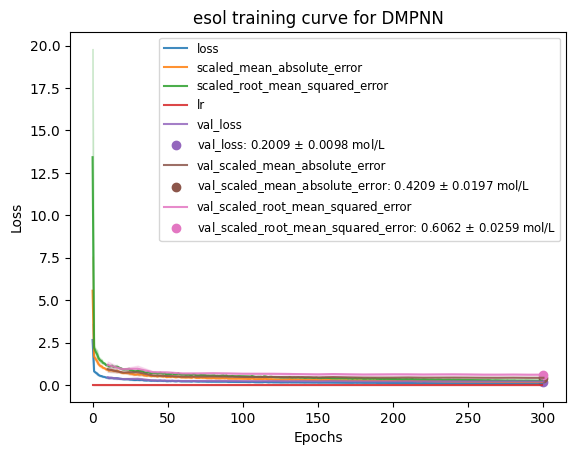

In [13]:
from kgcnn.utils.plots import plot_train_test_loss, plot_predict_true

plot_train_test_loss(history_list, loss_name=None, val_loss_name=None,
                     model_name="DMPNN", data_unit="mol/L", dataset_name="esol",
                     filepath="", file_name=f"loss.png");

8/8 [==============================] - 0s 6ms/step


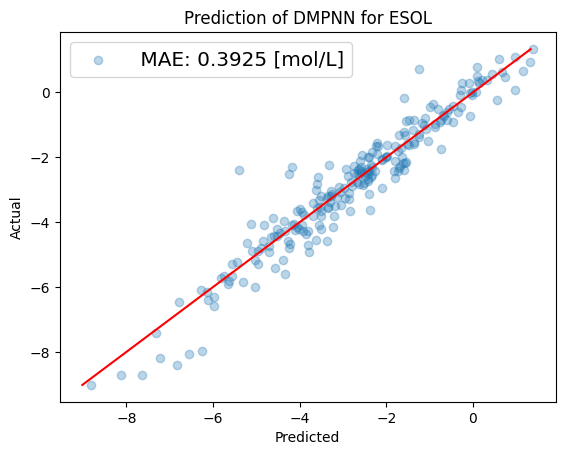

In [15]:
# Plot prediction for the last split.
predicted_y = model.predict(x_test)
true_y = y_test

# Predictions must be rescaled to original values.
predicted_y = scaler.inverse_transform(predicted_y)
true_y = scaler.inverse_transform(true_y)

# Plotting the prediction vs. true test targets for last split. Note for classification this is also done but
# can be ignored.
plot_predict_true(predicted_y, true_y,
                  filepath="", data_unit="mol/L",
                  model_name="DMPNN", dataset_name="ESOL",
                  file_name=f"predict.png");